# **2019厦门国际银行“数创金融杯”数据建模大赛**

## 任务

- 信用风险是金融监管机构重点关注的风险，关乎金融系统运行的稳定。在实际业务开展和模型构建过程中，面临着高维稀疏特征以及样本不平衡等各种问题，如何应用机器学习等数据挖掘方法提高信用风险的评估和预测能力，是各家金融机构积极探索的方向。本次竞赛提供实际业务场景中的信贷数据作为建模的对象，希望能借此展现各参赛选手数据挖掘的实战能力。

## 加载数据

- 本次数据共分为两个数据集，train_x.csv、train_target.csv和test_x.csv，其中train_x.csv为训练集的特征，train_target.csv为训练集的目标变量，其中，为了增强模型的泛化能力，训练集由两个阶段的样本组成，由字段isNew标记。test_x.csv为测试集的特征，特征变量与训练集一致。建模的目标即根据训练集对模型进行训练，并对测试集进行预测。


- 用户征信相关信息

  x_0至x_78以及ncloseCreditCard, unpayIndvLoan, unpayOtherLoan, unpayNormalLoan, 5yearBadloan该部分数据涉及较为第三方敏感数据，未做进一步说明。

In [1]:
%%html
<img src="./data/userinfo.png", width=320, heigth=240>
<img src="./data/loans_info.png", width=320, heigth=240>

In [1]:
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime
from scipy import sparse

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline


from tqdm import tqdm


# machine learning: XGB
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

In [2]:
## D:\study\notebook\2019厦门国际银行“数创金融杯”数据建模大赛\data
path = r'D:\study\notebook\2019厦门国际银行“数创金融杯”数据建模大赛\data\\'

train_x_file = path + 'train.csv'
train_target_file = path + 'train_target.csv'
test_x_file = path + 'test.csv'

In [3]:
def load_data():
    train_x = pd.read_csv(train_x_file,low_memory = False,)
    train_y = pd.read_csv(train_target_file,low_memory = False)
    test_x = pd.read_csv(test_x_file,low_memory = False)
    return train_x,train_y,test_x

In [4]:
train_x,train_y,test_x = load_data()
data = train_x.merge(train_y, on='id', how='left')
data.head()

,id,certId,loanProduct,gender,age,dist,edu,job,lmt,basicLevel,...,linkRela,setupHour,weekday,ncloseCreditCard,unpayIndvLoan,unpayOtherLoan,unpayNormalLoan,5yearBadloan,isNew,target
0,1,640582,1,2,27,640500,0,8,5.963,3,...,0,9,6,1,0,1,0,0,1,0
1,2,621023,2,2,25,640600,0,3,6.467,3,...,11,6,5,1,0,1,0,0,1,0
2,3,641283,1,2,37,641200,70,5,0.596,1,...,0,1,6,0,0,0,0,0,1,0
3,4,340821,3,2,29,340821,0,4,6.300,3,...,-999,13,6,1,0,1,0,0,1,0
4,5,732628,2,2,22,732628,0,2,6.700,2,...,11,8,3,1,0,1,0,0,1,0


In [5]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132029 entries, 0 to 132028
Columns: 104 entries, id to isNew
dtypes: float64(3), int64(101)
memory usage: 104.8 MB


In [6]:
train_x.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

In [7]:
train_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132029 entries, 0 to 132028
Data columns (total 2 columns):
id        132029 non-null int64
target    132029 non-null int64
dtypes: int64(2)
memory usage: 2.0 MB


In [8]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23561 entries, 0 to 23560
Columns: 104 entries, id to isNew
dtypes: float64(2), int64(102)
memory usage: 18.7 MB


## EDA

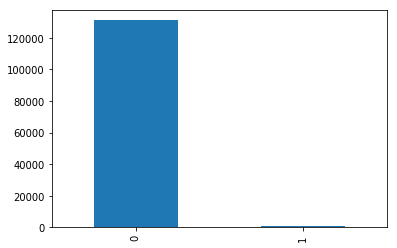

In [9]:
train_y.target.value_counts().plot(kind='bar')

>**分析：** 可以看出样本中 **target** 变量存在严重的数据不平衡。需要使用技术手段进行样本平衡，例如：上采样、下采样、SMOTE等。

> - **过采样（oversampling）和欠采样（undersampling）** 
> 最简单的方法只需要对处理步骤进行一点点修改，并简单地涉及到调整样本集直到它们达到平衡。过采样会随机复制少数样例以增大它们的规模。欠采样则随机地少采样主要的类。一些数据科学家（天真地）认为过采样更好，因为其会得到更多的数据，而欠采样会将数据丢掉。但请记住复制数据不是没有后果的——因为其会得到复制出来的数据，它就会使变量的方差表面上比实际上更小。而过采样的好处是它也会复制误差的数量：如果一个分类器在原始的少数类数据集上做出了一个错误的负面错误，那么将该数据集复制五次之后，该分类器就会在新的数据集上出现六个错误。相对地，欠采样会让独立变量（independent variable）的方差看起来比其实际的方差更高。

> - **SMOTE（Synthetic Minority Oversampling TEchnique：合成少数类过采样技术）**
> 其思想是通过在已有的样本间插值来创造新的少数类样本。具体参考：https://www.cnblogs.com/zhizhan/p/5821542.html


In [10]:
data.shape

(132029, 105)

In [11]:
train_x.columns

Index(['id', 'certId', 'loanProduct', 'gender', 'age', 'dist', 'edu', 'job',
       'lmt', 'basicLevel',
       ...
       'highestEdu', 'linkRela', 'setupHour', 'weekday', 'ncloseCreditCard',
       'unpayIndvLoan', 'unpayOtherLoan', 'unpayNormalLoan', '5yearBadloan',
       'isNew'],
      dtype='object', length=104)

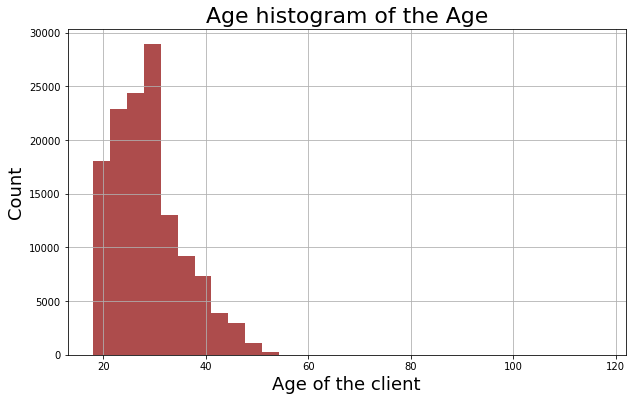

In [12]:
plt.xlabel("Age of the client",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Age histogram of the Age",fontsize=22)
train_x['age'].hist(bins=30,color='darkred',alpha=0.7,figsize=(10,6))

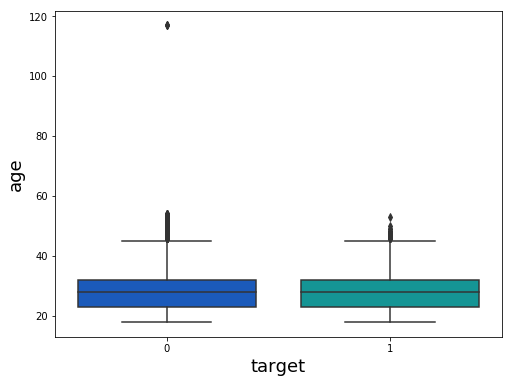

In [13]:
plt.figure(figsize=(8, 6))
plt.xlabel("target",fontsize=18)
plt.ylabel("Age",fontsize=18)
sns.boxplot(x='target',y='age',data=data,palette='winter')

> 可以看出**年龄（age）**对目标目标变量区分度不高，年龄因素可能不是产生预期的主要原因。

In [32]:
data[(data.target == 0)].edu.value_counts()

 0      128766
 40        873
 30        741
 20        312
 70        272
 60         51
 10         34
-999        18
 47          3
Name: edu, dtype: int64

In [24]:
data[(data.target == 1)].edu.value_counts()

0     956
30      2
70      1
Name: edu, dtype: int64

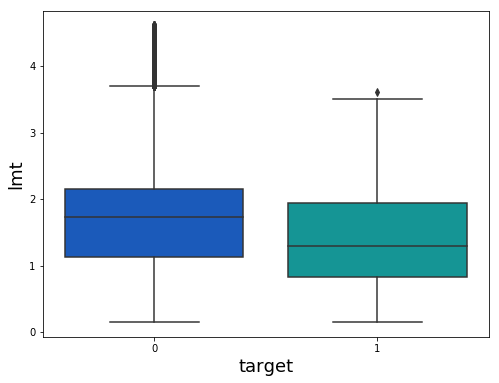

In [14]:
plt.figure(figsize=(8, 6))
plt.xlabel("target",fontsize=18)
plt.ylabel("lmt",fontsize=18)
temp = data[['lmt','target']]
temp['lmt'] = np.log1p(temp['lmt'])
sns.boxplot(x='target',y='lmt',data=temp,palette='winter')

> 
> （1:违约，0：正常）可以看出产生违约的贷款授信额度总体要小于正常贷款的授信金额，也就是说预授信金额（lmt）越高，违约的可能性越低，说明这是个很好的特征，具有较高的区分度。

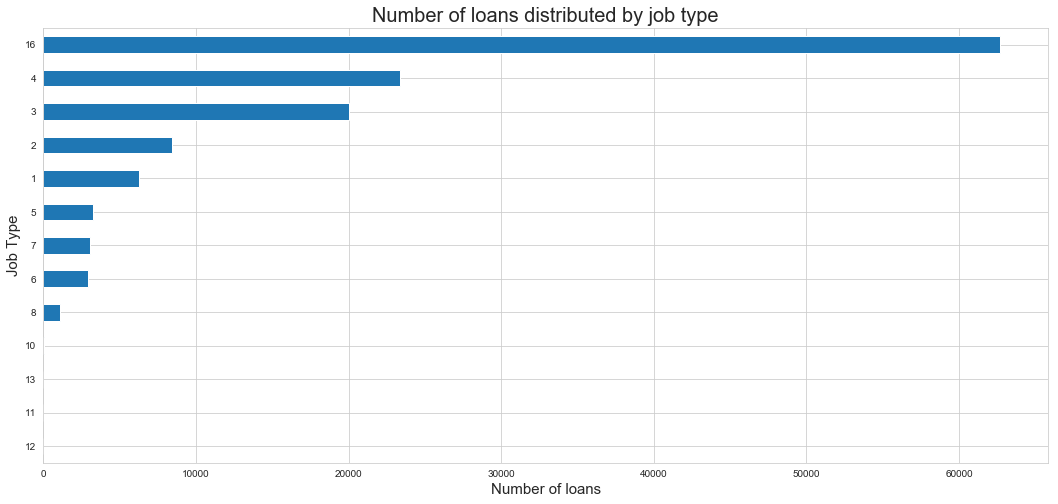

In [15]:
#正常贷款
sns.set_style('whitegrid')
#subplot(numRows, numCols, plotNum)
plt.figure()

data['job'].fillna(value=0,inplace=True)
temp = data[(data.target == 0)]['job'].value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(18,8))

plt.title('Number of loans distributed by job type',fontsize=20)
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Job Type',fontsize=15);

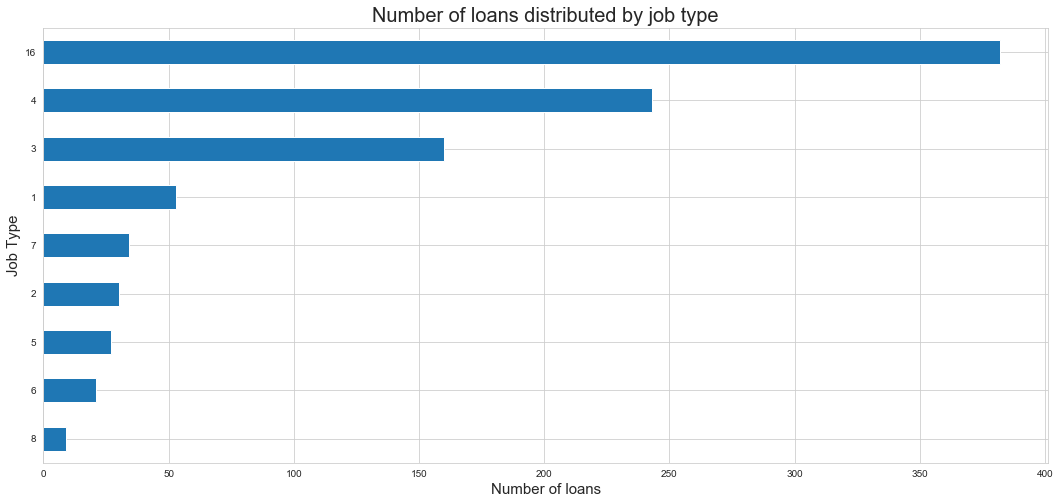

In [16]:
#违约贷款
sns.set_style('whitegrid')
data['job'].fillna(value=0,inplace=True)
data[(data.target == 1)]['job'].value_counts().sort_values().plot(kind='barh',figsize=(18,8))
plt.title('Number of loans distributed by job type',fontsize=20)
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Job Type',fontsize=15);

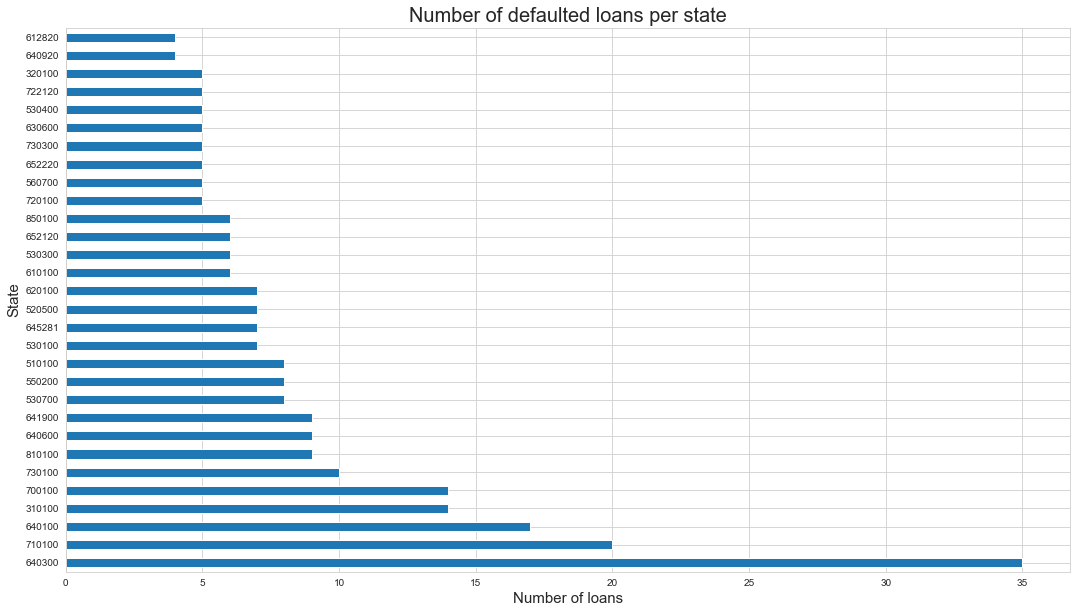

In [17]:
#违约贷款
fig = plt.figure(figsize=(18,10))
data[data['target']== 1].groupby('dist')['target'].count().sort_values(ascending=False).head(30).plot(kind='barh')
plt.ylabel('State',fontsize=15)
plt.xlabel('Number of loans',fontsize=15)
plt.title('Number of defaulted loans per state',fontsize=20);

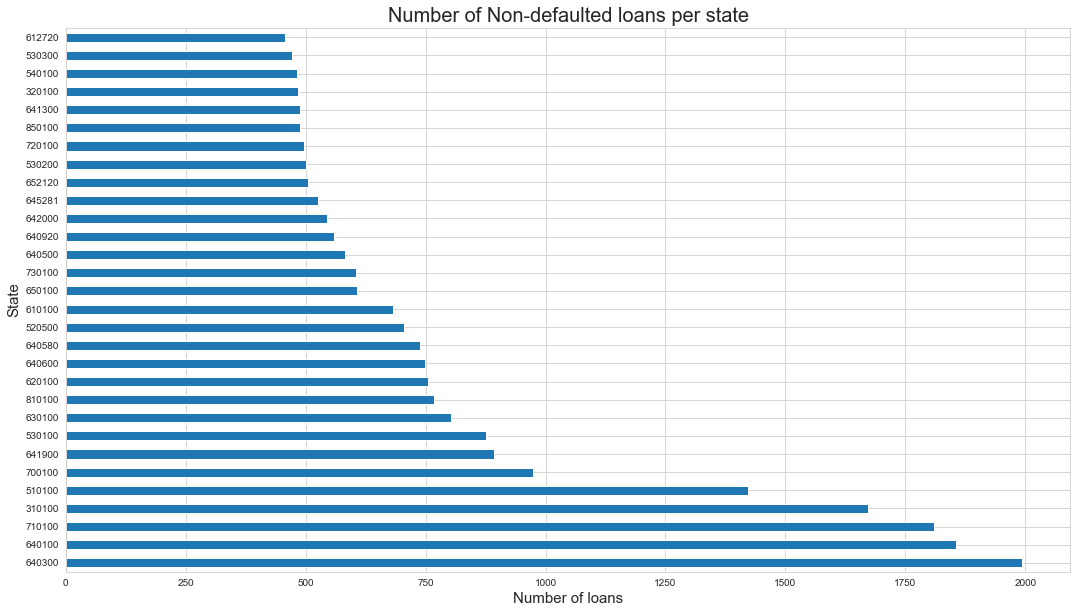

In [18]:
# 正常贷款
fig = plt.figure(figsize=(18,10))
data[data['target']== 0].groupby('dist')['target'].count().sort_values(ascending=False).head(30).plot(kind='barh')
plt.ylabel('State',fontsize=15)
plt.xlabel('Number of loans',fontsize=15)
plt.title('Number of Non-defaulted loans per state',fontsize=20);

可以看出，640300、640100等的地区中，违约和正常的贷款均是最多的，所以地区编码不能很好地代码客户质量。

## 数据预处理

### 缺失值

In [19]:
#Reffer From:https://www.kaggle.com/kernels/scriptcontent/5167439/
def null_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [20]:
# Missing values statistics
miss_values = null_values(train_x)
miss_values.head(20)

Dataframe has 104 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
bankCard,20152,15.3


> 可以看出，其他通过业务处理过的缺失值除外，仅有bankCard变量存在缺失值（NaN）。

### 特征构造

In [21]:
print(train_x.columns[:20])
print(train_x.columns[20:40])
print(train_x.columns[40:60])
print(train_x.columns[60:80])
print(train_x.columns[80:])

Index(['id', 'certId', 'loanProduct', 'gender', 'age', 'dist', 'edu', 'job',
       'lmt', 'basicLevel', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6',
       'x_7', 'x_8', 'x_9'],
      dtype='object')
Index(['x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18',
       'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27',
       'x_28', 'x_29'],
      dtype='object')
Index(['x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38',
       'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47',
       'x_48', 'x_49'],
      dtype='object')
Index(['x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58',
       'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64', 'x_65', 'x_66', 'x_67',
       'x_68', 'x_69'],
      dtype='object')
Index(['x_70', 'x_71', 'x_72', 'x_73', 'x_74', 'x_75', 'x_76', 'x_77', 'x_78',
       'certValidBegin', 'certValidStop', 'bankCard', 'ethnic', 'residentAddr',
       'highestEdu', 'li

In [88]:
#定义特征处理函数
from sklearn.preprocessing import StandardScaler
## import labelencoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

#refer from:https://www.kaggle.com/samratp/lightgbm-xgboost-catboost
def drop_sparse(train, test):
    flist = [x for x in train.columns if not x in ['ID','target']]
    for f in flist:
        if len(np.unique(train[f]))<2:
            train.drop(f, axis=1, inplace=True)
            test.drop(f, axis=1, inplace=True)
    return train, test


def transform_feature(df,shrink_x=False,train=True):
    temp = df.copy(deep=True)
    
    if shrink_x:
        #合并30天内预期
        temp['x_0_30'] = temp['x_0']
        temp.drop(['x_0'],axis=1,inplace=True)
        for i in range(1,31):
            loc='x_'+str(i)
            temp['x_0_30'] = temp['x_0_30'] + temp[loc]
            temp.drop([loc],axis=1,inplace=True)    
        #print(loc)
        
        temp['x_31_60'] = temp['x_31']
        temp.drop(['x_31'],axis=1,inplace=True)
        for i in range(32,61):
            loc='x_'+str(i)
            temp['x_31_60'] = temp['x_31_60'] + temp[loc]
            temp.drop([loc],axis=1,inplace=True)
        #print(loc)
        
        temp['x_60+'] = temp['x_61']
        temp.drop(['x_61'],axis=1,inplace=True)
        for i in range(62,79):
            loc='x_'+str(i)
            temp['x_60+'] = temp['x_60+'] + temp[loc]
            temp.drop([loc],axis=1,inplace=True)
        #print(loc)
            
    #居住地和申请地城市是否一致:
    #0:一致   1：不一致
    temp['certId'] = temp.certId.astype(str)
    temp['dist'] = temp.dist.astype(str)
    temp['residentAddr'] = temp.residentAddr.astype(str)

    temp['is_moving'] = temp.apply(lambda x:0 if  x['residentAddr'][0:4] == x['dist'][0:4] else 1, axis=1)
    temp['dist'] = temp['dist'].apply(lambda x: x[0:4])
    #temp.drop(['certId','residentAddr'],axis=1,inplace=True)
    
    #卡号信息处理，获取银行信息
    #相当于完成一次简单的聚类
    from cardbin import BANKBIN
    def getbankinfo(cardbin):
        key = BANKBIN.get(cardbin[:6]) if BANKBIN.get(
            cardbin[:7]) else BANKBIN.get(cardbin[:6], None)
        if key:
            key = key.split('|')
            return key[0]
        return  '其他银行'
    
    temp.fillna(-999, inplace=True)
    temp['bankCard'] = temp['bankCard'].astype(int)
    temp['bankCard'] = temp['bankCard'].astype(str)
    temp['cardbin'] = temp['bankCard'].apply(lambda x: x[0:6])
    temp['bankname'] = temp.cardbin.apply(lambda x: getbankinfo(x))
    bankname = pd.get_dummies(temp['bankname'],prefix="bankname",drop_first=True)
    temp.drop(['bankCard','cardbin','bankname','bankCard'],axis=1,inplace=True)
    temp = pd.concat([temp,bankname],axis=1)

    #将年龄进行分箱处理    
    bins = [-np.inf, 18, 30, 35,40,50,60, np.inf]
    labels = ['age_18-', 'age_18_30', 'age_30_35','age_35_40', 'age_40_50', 'age50_60', 'age_60+']
    temp['age_info'] = pd.cut(temp["age"], bins, labels = labels).astype('object')
    ## instantiate labelencoder object
    le = LabelEncoder()
    ## apply le on categorical feature columns
    temp['age_info'] = temp[['age_info']].apply(lambda col: le.fit_transform(col))

    #Convert categorial feature like 'gender' and 'edu' to dummy variables
    job = pd.get_dummies(temp['job'],prefix="job",drop_first=True)
    loanProduct = pd.get_dummies(temp['loanProduct'],prefix="loanProduct",drop_first=True)
    gender = pd.get_dummies(temp['gender'],prefix="gender",drop_first=True)
    edu = pd.get_dummies(temp['edu'],prefix="edu",drop_first=True)
    highestEdu = pd.get_dummies(temp['highestEdu'],prefix="highestEdu",drop_first=True)
    ethnic = pd.get_dummies(temp['ethnic'],prefix="ethnic",drop_first=True)
    weekday = pd.get_dummies(temp['weekday'],prefix="weekday",drop_first=True)
    dist = pd.get_dummies(temp['dist'],prefix="dist",drop_first=True)
    
    temp.drop(['job','loanProduct','gender','edu','highestEdu','ethnic','weekday','dist','age','certId','residentAddr'],axis=1,inplace=True)
    temp = pd.concat([temp,job,loanProduct,gender,edu,highestEdu,ethnic,weekday,dist],axis=1)
    
    #TODO:删除暂时不处理的列
    temp.drop(['id','certValidBegin','certValidStop','isNew'],axis=1,inplace=True)
    
    #print("feature:")
    #print(temp.columns[:21].values)
    #print(temp.columns[21:].values)
   
    #temp.fillna(0,inplace=True)
    #temp.replace(np.NaN,0,inplace=True)
    
    #return temp
    if train:
        features=temp.columns.tolist()
        features.remove('target')
    
        X = temp[features]
        y = temp['target']
        
        sc = StandardScaler()
        X_train = sc.fit_transform(X)
        
        sm = SMOTE(random_state=12, ratio = 1.0)
        X_r, y_r = sm.fit_sample(X, y)
        
        X = pd.DataFrame(X_r,columns=features)
        y = pd.DataFrame(y_r, columns=['target'])
        print("training dataset build finish!")
        return X, y
    else:
        features=temp.columns.tolist()
        X = temp[features]
        print("test dataset build finish!")
        return X

In [84]:
X,y  = transform_feature(data)

In [91]:
X.head()

,lmt,basicLevel,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,dist_8528,dist_8529,dist_8530,dist_8531,dist_8532,dist_8540,dist_8541,dist_8542,dist_8543,dist_8590
0,5.963,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.467,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.596,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.300,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.700,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
X_submission = transform_feature(test_x,train=False)

test dataset build finish!


In [92]:
X_submission.head()

,lmt,basicLevel,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,dist_8523,dist_8527,dist_8528,dist_8529,dist_8531,dist_8540,dist_8541,dist_8542,dist_8543,dist_8590
0,9.963,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.730,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.768,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17.233,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.463,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
print("feature:")
print(X_submission.columns[:21].values)
print(X_submission.columns[21:].values)

feature:
['lmt' 'basicLevel' 'x_0' 'x_1' 'x_2' 'x_3' 'x_4' 'x_5' 'x_6' 'x_7' 'x_8'
 'x_9' 'x_10' 'x_11' 'x_12' 'x_13' 'x_14' 'x_15' 'x_16' 'x_17' 'x_18']
['x_19' 'x_20' 'x_21' 'x_22' 'x_23' 'x_24' 'x_25' 'x_26' 'x_27' 'x_28'
 'x_29' 'x_30' 'x_31' 'x_32' 'x_33' 'x_34' 'x_35' 'x_36' 'x_37' 'x_38'
 'x_39' 'x_40' 'x_41' 'x_42' 'x_43' 'x_44' 'x_45' 'x_46' 'x_47' 'x_48'
 'x_49' 'x_50' 'x_51' 'x_52' 'x_53' 'x_54' 'x_55' 'x_56' 'x_57' 'x_58'
 'x_59' 'x_60' 'x_61' 'x_62' 'x_63' 'x_64' 'x_65' 'x_66' 'x_67' 'x_68'
 'x_69' 'x_70' 'x_71' 'x_72' 'x_73' 'x_74' 'x_75' 'x_76' 'x_77' 'x_78'
 'linkRela' 'setupHour' 'ncloseCreditCard' 'unpayIndvLoan'
 'unpayOtherLoan' 'unpayNormalLoan' '5yearBadloan' 'is_moving'
 'bankname_中国工商银行' 'bankname_中国建设银行' 'bankname_中国银行' 'bankname_交通银行'
 'bankname_光大银行' 'bankname_兴业银行' 'bankname_其他银行' 'bankname_农业银行'
 'bankname_华夏银行' 'bankname_工商银行' 'bankname_平安银行' 'bankname_建设银行'
 'bankname_招商银行' 'bankname_民生银行' 'bankname_浦东发展银行' 'bankname_邮储银行'
 'bankname_邮政储蓄银行' 'age_info' 'j

In [113]:
print("feature:")
print(X.columns[:21].values)
print(X.columns[21:].values)

feature:
['lmt' 'basicLevel' 'x_0' 'x_1' 'x_2' 'x_3' 'x_4' 'x_5' 'x_6' 'x_7' 'x_8'
 'x_9' 'x_10' 'x_11' 'x_12' 'x_13' 'x_14' 'x_15' 'x_16' 'x_17' 'x_18']
['x_19' 'x_20' 'x_21' 'x_22' 'x_23' 'x_24' 'x_25' 'x_26' 'x_27' 'x_28'
 'x_29' 'x_30' 'x_31' 'x_32' 'x_33' 'x_34' 'x_35' 'x_36' 'x_37' 'x_38'
 'x_39' 'x_40' 'x_41' 'x_42' 'x_43' 'x_44' 'x_45' 'x_46' 'x_47' 'x_48'
 'x_49' 'x_50' 'x_51' 'x_52' 'x_53' 'x_54' 'x_55' 'x_56' 'x_57' 'x_58'
 'x_59' 'x_60' 'x_61' 'x_62' 'x_63' 'x_64' 'x_65' 'x_66' 'x_67' 'x_68'
 'x_69' 'x_70' 'x_71' 'x_72' 'x_73' 'x_74' 'x_75' 'x_76' 'x_77' 'x_78'
 'linkRela' 'setupHour' 'ncloseCreditCard' 'unpayIndvLoan'
 'unpayOtherLoan' 'unpayNormalLoan' '5yearBadloan' 'is_moving'
 'bankname_中国工商银行' 'bankname_中国建设银行' 'bankname_中国银行' 'bankname_交通银行'
 'bankname_光大银行' 'bankname_兴业银行' 'bankname_其他银行' 'bankname_农业银行'
 'bankname_华夏银行' 'bankname_工商银行' 'bankname_平安银行' 'bankname_建设银行'
 'bankname_招商银行' 'bankname_民生银行' 'bankname_浦东发展银行' 'bankname_邮储银行'
 'bankname_邮政储蓄银行' 'age_info' 'j

In [81]:
import gc
gc.collect()

20

## 特征选择

### 使用lightgbm选择特征

In [94]:
#df_train = df.copy(deep=True)
X,y  = transform_feature(data)

df_train = X
target =  y
df_train_columns=df_train.columns.tolist()

param = {'num_leaves': 51,
         'min_data_in_leaf': 50, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'auc',  #按照要求使用AUC进行训练评估
         "lambda_l1": 0.01,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 666}
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=666)
oof = np.zeros(len(df_train))
#predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,target['target'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

training dataset build finish!
fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.996102	valid_1's auc: 0.995572
[200]	training's auc: 0.998075	valid_1's auc: 0.997697
[300]	training's auc: 0.998378	valid_1's auc: 0.998011
[400]	training's auc: 0.998503	valid_1's auc: 0.998104
[500]	training's auc: 0.998641	valid_1's auc: 0.99818
[600]	training's auc: 0.998869	valid_1's auc: 0.998253
[700]	training's auc: 0.999225	valid_1's auc: 0.998281
[800]	training's auc: 0.999493	valid_1's auc: 0.998286
Early stopping, best iteration is:
[768]	training's auc: 0.999415	valid_1's auc: 0.99829
fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.996147	valid_1's auc: 0.996214
[200]	training's auc: 0.998023	valid_1's auc: 0.998094
[300]	training's auc: 0.998337	valid_1's auc: 0.998422
[400]	training's auc: 0.998466	valid_1's auc: 0.998526
[500]	training's auc: 0.998607	valid_1's auc: 0.998593
[600]	training's auc: 0.99

KeyboardInterrupt: 

In [78]:
from sklearn.metrics import roc_auc_score
roc_auc_score(target,oof)

0.7155885109589293

In [ ]:
ax = clf.plot_importance(gbm, max_num_features=10)
plt.show()
 
ax = clf.plot_tree(gbm)
plt.show()

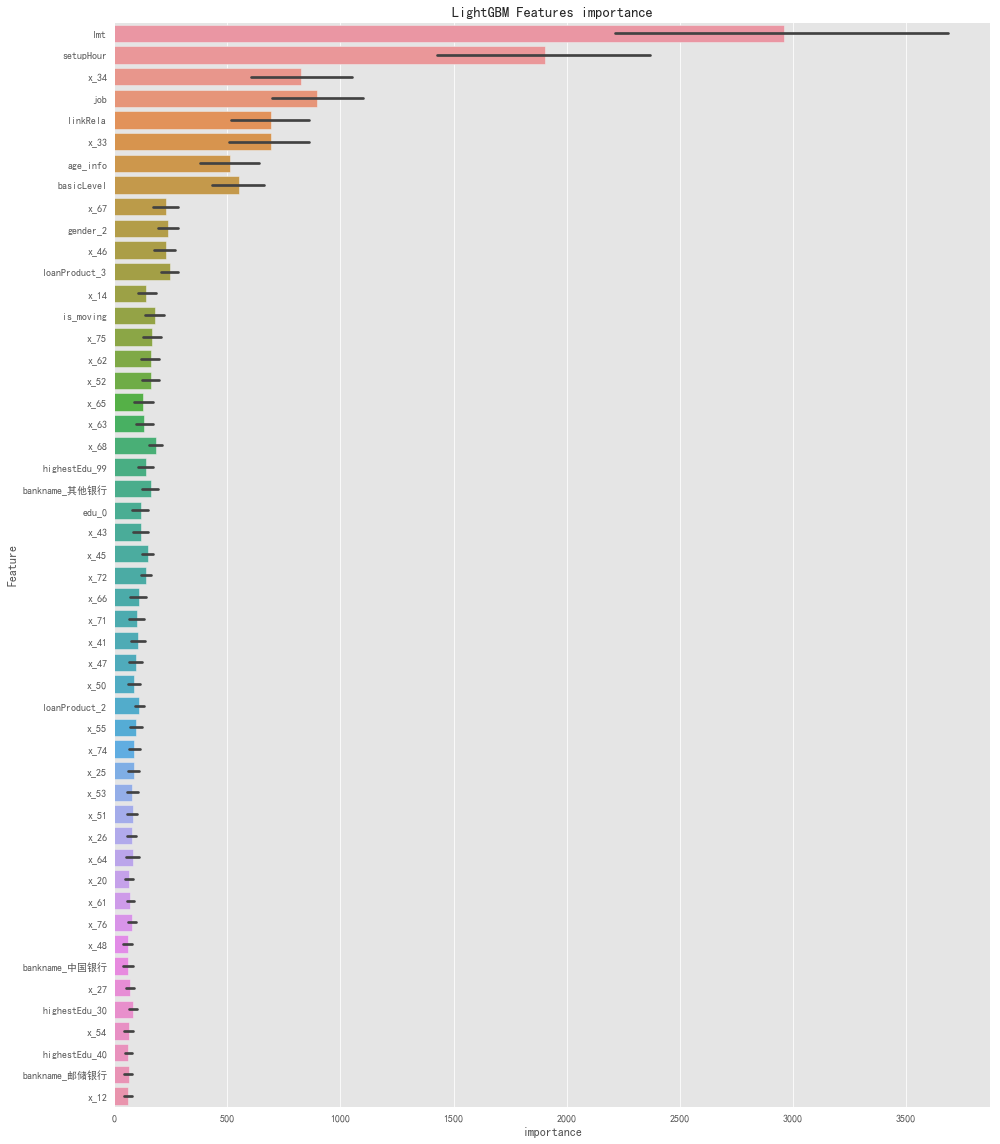

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'  #解决中文显示问题
plt.style.use('ggplot') #自带的美化方式

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,16))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features importance')
plt.tight_layout()

In [84]:
features = best_features[['Feature','importance']].sort_values(by="importance",ascending=False)
features = np.unique(features['Feature'][:100].values)
features = list(features)
features

['age_info',
 'basicLevel',
 'gender_2',
 'is_moving',
 'job',
 'linkRela',
 'lmt',
 'loanProduct_3',
 'setupHour',
 'x_14',
 'x_33',
 'x_34',
 'x_46',
 'x_52',
 'x_62',
 'x_67',
 'x_75']

## 模型参数估计

In [101]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score

In [99]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))   
        print("roc_auc_score: \n {}\n".format(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1] )))

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,random_state=101)

In [102]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=20, random_state=21)
clf_rf.fit(X, y)
print_score(clf_rf, x_train_r, y_train_r, X_test, y_test, train=False)

C:\Users\baiziru\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Test Result:

accuracy score: 0.9998

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19786
           1       1.00      1.00      1.00     19535

    accuracy                           1.00     39321
   macro avg       1.00      1.00      1.00     39321
weighted avg       1.00      1.00      1.00     39321


Confusion Matrix: 
 [[19786     0]
 [    9 19526]]

roc_auc_score: 
 1.0



### LogisticRegression Modeling

In [171]:
from sklearn.linear_model import LogisticRegression
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,random_state=101)
model_lrg = LogisticRegression(C = 0.05,random_state=21)
model_lrg.fit(X_train, y_train)
print_score(model_lrg, X_train, y_train, X_test, y_test, train=False)

C:\Users\baiziru\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test Result:

accuracy score: 0.7435

Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.72      0.74     19786
           1       0.73      0.77      0.75     19535

    accuracy                           0.74     39321
   macro avg       0.74      0.74      0.74     39321
weighted avg       0.74      0.74      0.74     39321


Confusion Matrix: 
 [[14248  5538]
 [ 4549 14986]]

roc_auc_score: 
 0.8138573548331364



###  LightGBM  Modeling
- http://lightgbm.apachecn.org/cn/latest/index.html
- lightGBM包含两个关键点：light即轻量级，GBM 梯度提升机。

In [191]:
#import shap

In [189]:
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "binary",
        "boosting_type": "gbdt",
        "metric" : "auc",
        "num_leaves" : 100,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "max_bin": 512,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    #pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return model, evals_result

In [192]:
# Training LGB
#X,y  = transform_feature(data)
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,random_state=101)
model_lgb, evals_result = run_lgb(X_train, y_train, X_test, y_test)
print("LightGBM Training Completed...")

Training until validation scores don't improve for 100 rounds.
[150]	training's auc: 0.999928	valid_1's auc: 0.998489
Early stopping, best iteration is:
[97]	training's auc: 0.999279	valid_1's auc: 0.998619
LightGBM Training Completed...


In [175]:
# feature importance
print("Features Importance...")
gain = model_lgb.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model_lgb.feature_name(), 
                   'split':model_lgb.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp[:10])

Features Importance...
            feature  split       gain
48             x_46   1068  13.963250
47             x_45   1062   7.973938
77             x_75   1358   7.364785
69             x_67   1714   6.469777
88        is_moving   2213   4.860900
109           job_4   2688   3.931035
74             x_72   1196   3.311284
121        gender_2   2329   2.910026
85   unpayOtherLoan    448   2.758023
35             x_33   2770   2.654205


In [ ]:
# 保存模型到文件
print('Save model...')
model_lgb.save_model('model_lgb.txt')

###  XGBoost Modeling

In [195]:
def run_xgb(train_X, train_y, val_X, val_y):
    params = {'objective': 'binary:logistic', 
          'eval_metric': 'auc',
          'eta': 0.05,
          'max_depth': 100, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'nthread':4,
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 200, verbose_eval=100)
    
    #dtest = xgb.DMatrix(test_X)
    #xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return model_xgb

In [ ]:
# Training XGB
model_xgb = run_xgb(X_train, y_train, X_test, y_test)
print("XGB Training Completed...")

[0]	train-auc:0.997301	valid-auc:0.996435
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 200 rounds.
[100]	train-auc:0.999991	valid-auc:0.999152


In [ ]:
#[1039]	train-auc:0.977261	valid-auc:0.708885

### Combine Predictions

#### 构建与训练集相同维度的特征的测试集

In [186]:
X_test_submission = transform_feature(test_x,train=False)
df_X = pd.DataFrame(columns = X.columns)
for col in X.columns:
    if col  in X_test_submission.columns:
        df_X[col] = X_test_submission[col]
    else:
        df_X[col] = 0
        
import operator
print("调整前：")
print(operator.eq(list(X.columns),list(X_test_submission.columns)))
print("调整后：")
print(operator.eq(list(X.columns),list(df_X.columns)))

test dataset build finish!
True
False


In [187]:
test_x.head()

,id,certId,loanProduct,gender,age,dist,edu,job,lmt,basicLevel,...,highestEdu,linkRela,setupHour,weekday,ncloseCreditCard,unpayIndvLoan,unpayOtherLoan,unpayNormalLoan,5yearBadloan,isNew
0,132030,541202,1,2,28,540100,0,3,9.963,1,...,-999,0,9,6,1,0,1,0,0,1
1,132031,733521,1,1,42,730900,0,6,0.730,1,...,-999,0,4,6,1,0,1,0,0,1
2,132032,710231,1,2,43,710100,0,2,5.768,1,...,-999,0,18,5,1,1,1,0,0,1
3,132033,722122,3,2,32,722120,0,4,17.233,1,...,-999,-999,6,5,1,0,1,1,0,1
4,132034,641723,1,2,22,641700,0,4,0.463,3,...,-999,1,4,6,0,0,0,0,0,1


In [188]:
df_X.head()

,lmt,basicLevel,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,dist_8528,dist_8529,dist_8530,dist_8531,dist_8532,dist_8540,dist_8541,dist_8542,dist_8543,dist_8590
0,9.963,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.730,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.768,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17.233,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.463,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 使用训练好的模型进行预测

In [169]:
# 预测数据集
pred_yprob_lrg = model_lrg.predict_proba(df_X)
pred_y_lrg = model_lrg.predict(df_X)

#每个客户违约概率预测
y = pd.DataFrame(pred_yprob_lrg[:,1], columns=['target'])
y_pred_prob = pd.concat([test_x.id, y],axis=1)
#y_pred_prob.to_csv('sub_lrg_prob.csv', index=False)
#y_pred_prob.head()

#每个客户是否违约
y = pd.DataFrame(pred_y_lrg, columns=['target'])
y_pred = pd.concat([test_x.id, y],axis=1)
y_pred_prob.to_csv('sub_lrg_lable.csv', index=False)

y_pred.head()

,id,target
0,132030,0
1,132031,0
2,132032,0
3,132033,0
4,132034,1


In [ ]:
test_x.shape

In [184]:
# 预测数据集
#pred_lgb = np.expm1(model_lgb.predict(df_X, num_iteration=model_lgb.best_iteration))
pred_lgb = model_lgb.predict(df_X, num_iteration=model_lgb.best_iteration)

#每个客户是否违约
y = pd.DataFrame(pred_lgb, columns=['target'])
y_pred = pd.concat([test_x.id, y],axis=1)
y_pred_prob.to_csv('sub_lgb_lable.csv', index=False)

y_pred.head()

In [185]:
pred_lgb

array([0.01551073, 0.02586425, 0.01533486, ..., 0.0158809 , 0.01249904,
       0.01041978])

In [ ]:
# 预测数据集
pred_xgb = np.expm1(model_xgb.predict(df_X, num_iteration=model_xgb.best_iteration))

In [ ]:
#sub = pd.read_csv('../input/sample_submission.csv')

sub_lrg = pd.DataFrame()
sub_lrg["target"] = pred_lrg

sub_lgb = pd.DataFrame()
sub_lgb["target"] = pred_lgb

sub_xgb = pd.DataFrame()
sub_xgb["target"] = pred_xgb

sub["target"] = ( sub_lrg["target"] * 0.2 + sub_lgb["target"] * 0.5 + sub_xgb["target"] * 0.3 )

print(sub.head())
sub.to_csv('sub_lr_lgb_xgb.csv', index=False)

##  模型评价
二分类问题在机器学习中是一个很常见的问题，经常会用到。ROC (Receiver Operating Characteristic) 曲线和 AUC (Area Under the Curve)(Area Under theCurve) 值常被用来评价一个二值分类器 (binary classifier) 的优劣。

对于分类器，或者说分类算法，评价指标主要有precision，recall，F-score等，以及这里要讨论的ROC和AUC。
AUC(Area under the ROC curve)
ROC曲线一定程度上可以反映分类器的分类效果，但是不够直观，我们希望有这么一个指标，如果这个指标越大越好，越小越差，于是，就有了AUC。AUC实际上就是ROC曲线下的面积。AUC直观地反映了ROC曲线表达的分类能力。

 - AUC ＝ 1，代表完美分类器
 - 0.5 < AUC < 1，优于随机分类器
 - 0 < AUC < 0.5，差于随机分类器

**总结：**
 - ROC曲线反映了分类器的分类能力，结合考虑了分类器输出概率的准确性
 - AUC量化了ROC曲线的分类能力，越大分类效果越好，输出概率越合理
 - AUC常用作CTR的离线评价，AUC越大，CTR的排序能力越强


作者：尼小摩
链接：<a href='https://www.jianshu.com/p/848838ecbc2d'>https://www.jianshu.com/p/848838ecbc2d</a>
来源：简书
著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

In [108]:
#计算ROC曲线的AUC值
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score
#area = metrics.roc_auc_score(label, prob)
#print(area)

In [ ]:
X_test_submission = transform_feature(test_x,train=False)

y_scores = model.predict_proba(X_test)
y_scores = y_scores[:,1]

auroc = roc_auc_score(y_test, y_scores)

print("ROC-AUC Score:", auroc)

## 提交结果

> **提交数据格式说明**
> - 1. 参赛者提交CSV结果文件；
> - 2. 文件内容分为两列，第一列为“id”（即用户id），第二列为”target”(坏样本的概率)； 
> - 3. 复赛阶段参赛队伍须向大赛组委会邮箱（zhangzhiy@xib.com.cn）提交源代码和解决方案报告（如赛题分析与理解、建模流程设计、特征工程、模型选取与训练、模型评估、建模过程中的发现与创新点等）。组委会将进行代码审核，代码需具有通用性和普适性。同时，专家评分将综合考察解决方案中的创新性、复杂度、稳定性等多项指标；